Время исполнения (базовая модель): 0.05686020851135254 секунд(-ы)
Всего штрафов (базовая модель): 326.0
Время исполнения (островная модель): 0.32811713218688965 секунд(-ы)
Всего штрафов (островная модель): 11.0
Статистика Wilcoxon: 60.0
P-value: 1.1786899176185178e-17
Отвергаем нулевую гипотезу, результаты моделей статистически значимо различаются.
Лучшее расписание (базовая модель):


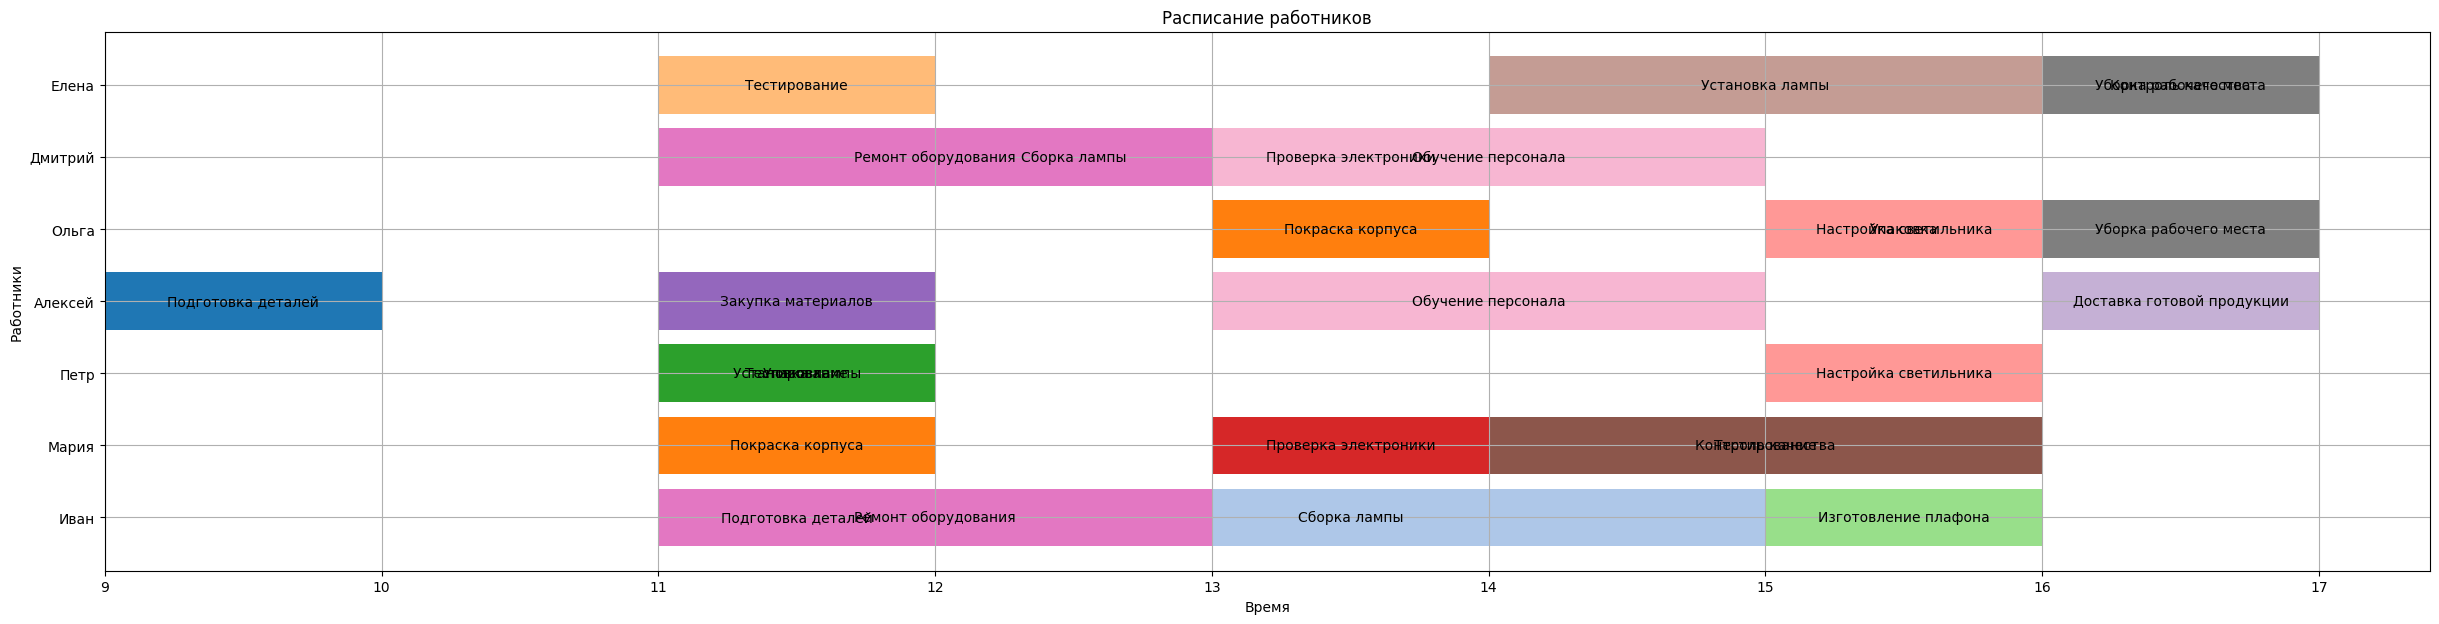

Лучшее расписание (островная модель):


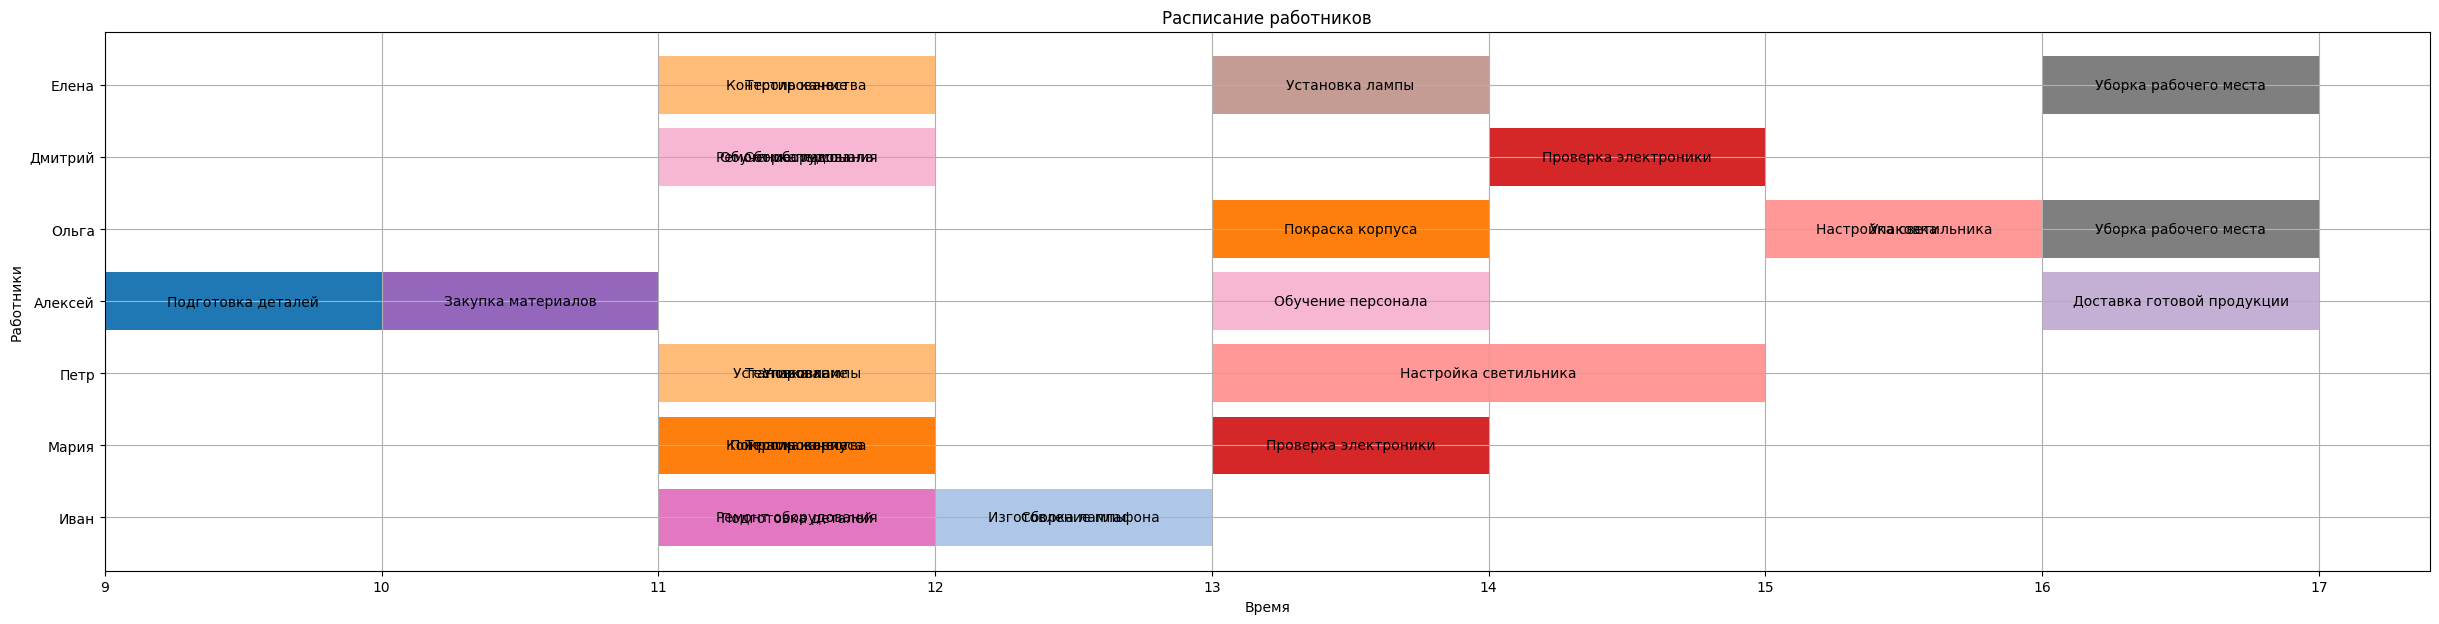

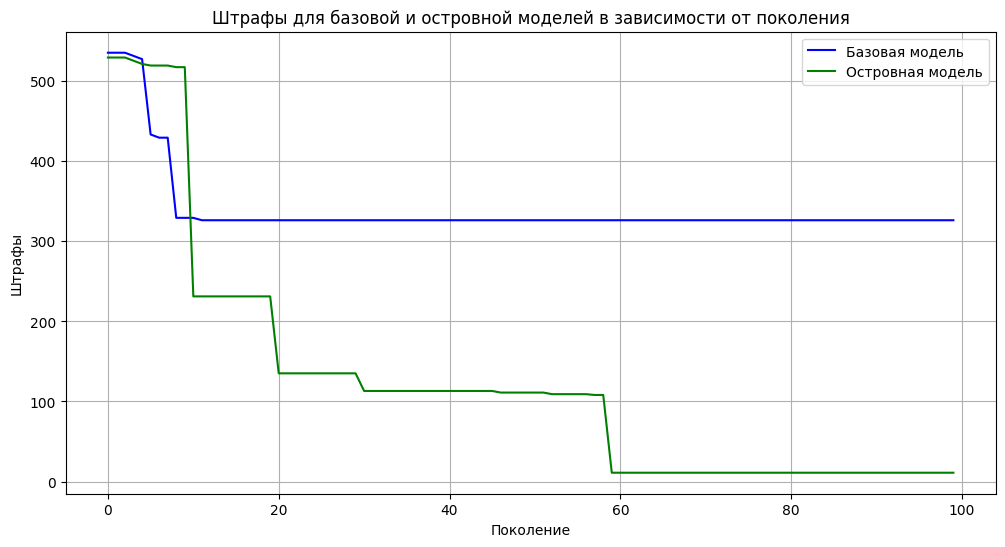

Число островов: 1
Время исполнения (островная модель): 0.10184144973754883 секунд(-ы)
Всего штрафов (островная модель): 513.0

Число островов: 2
Время исполнения (островная модель): 0.15769457817077637 секунд(-ы)
Всего штрафов (островная модель): 208.0

Число островов: 3
Время исполнения (островная модель): 0.21773338317871094 секунд(-ы)
Всего штрафов (островная модель): 125.0

Число островов: 4
Время исполнения (островная модель): 0.2713046073913574 секунд(-ы)
Всего штрафов (островная модель): 21.0

Число островов: 5
Время исполнения (островная модель): 0.3200855255126953 секунд(-ы)
Всего штрафов (островная модель): 31.0



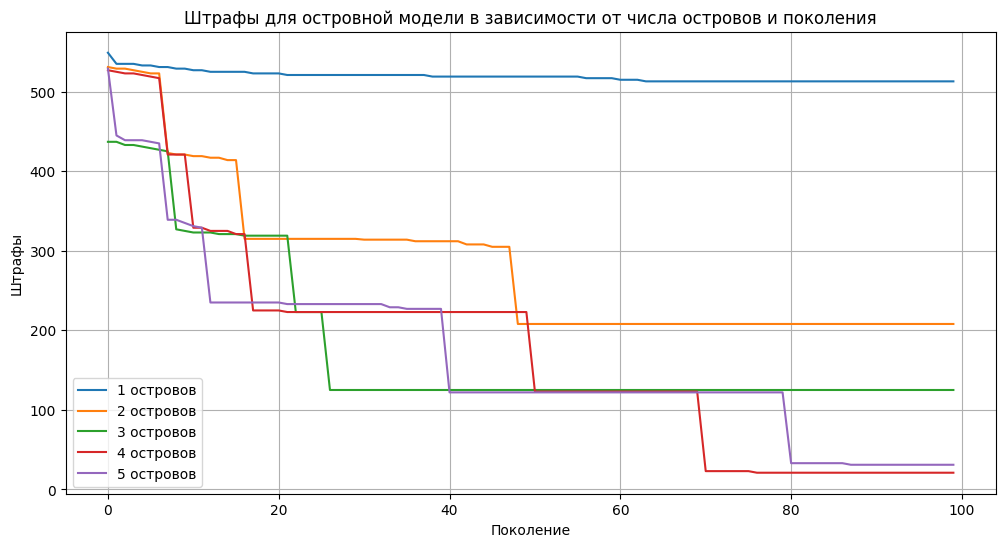

In [72]:
import numpy as np
import time
import random
from scipy.stats import wilcoxon  # Используем Wilcoxon signed-rank test
import matplotlib.pyplot as plt

#работа
works = [
     {"name": "Подготовка деталей", "start_time": 9, "end_time": 12, "duration": 1, "dependencies": []},
    {"name": "Сборка лампы", "start_time": 11, "end_time": 15, "duration": 3, "dependencies": ["Покраска корпуса"]},
    {"name": "Покраска корпуса", "start_time": 10, "end_time": 14, "duration": 1, "dependencies": ["Подготовка деталей"]},
    {"name": "Тестирование", "start_time": 13, "end_time": 16, "duration": 2, "dependencies": []},
    {"name": "Упаковка", "start_time": 15, "end_time": 17, "duration": 1, "dependencies": ["Тестирование"]},
    {"name": "Изготовление плафона", "start_time": 13, "end_time": 16, "duration": 1, "dependencies": ["Сборка лампы"]},
    {"name": "Проверка электроники", "start_time": 13, "end_time": 15, "duration": 1, "dependencies": []},
    {"name": "Настройка светильника", "start_time": 15, "end_time": 16, "duration": 1, "dependencies": ["Сборка лампы"]},
    {"name": "Закупка материалов", "start_time": 9, "end_time": 13, "duration": 1, "dependencies": []},
    {"name": "Доставка готовой продукции", "start_time": 16, "end_time": 17, "duration": 1, "dependencies": ["Упаковка"]},
    {"name": "Контроль качества", "start_time": 15, "end_time": 17, "duration": 1, "dependencies": ["Тестирование"]},
    {"name": "Установка лампы", "start_time": 14, "end_time": 16, "duration": 2, "dependencies": ["Упаковка"]},
    {"name": "Ремонт оборудования", "start_time": 10, "end_time": 14, "duration": 2, "dependencies": ["Подготовка деталей"]},
    {"name": "Обучение персонала", "start_time": 13, "end_time": 16, "duration": 2, "dependencies": []},
    {"name": "Уборка рабочего места", "start_time": 16, "end_time": 17, "duration": 1, "dependencies": []},
]

#работники
workers = [
    {"name": "Иван", "skills": ["Подготовка деталей", "Сборка лампы", "Изготовление плафона", "Ремонт оборудования"], "max_hours": 8},
    {"name": "Мария", "skills": ["Покраска корпуса", "Тестирование", "Проверка электроники", "Контроль качества"], "max_hours": 8},
    {"name": "Петр", "skills": ["Упаковка", "Тестирование", "Настройка светильника", "Установка лампы"], "max_hours": 8},
    {"name": "Алексей", "skills": ["Закупка материалов", "Подготовка деталей", "Доставка готовой продукции", "Обучение персонала"], "max_hours": 8},
    {"name": "Ольга", "skills": ["Покраска корпуса", "Настройка светильника", "Упаковка", "Уборка рабочего места"], "max_hours": 8},
    {"name": "Дмитрий", "skills": ["Сборка лампы", "Проверка электроники", "Ремонт оборудования", "Обучение персонала"], "max_hours": 8},
    {"name": "Елена", "skills": ["Тестирование", "Контроль качества", "Установка лампы", "Уборка рабочего места"], "max_hours": 8},
]

# Штрафы
PENALTY_ORDER_VIOLATION = 100  # Нарушение порядка выполнения
PENALTY_REVERSE_ORDER = 100    # Обратный порядок выполнения
PENALTY_LOW_QUALITY = 80       # Назначение на работу, которую работник не может выполнить качественно
PENALTY_OVERTIME = 100         # Рабочий день более 8 часов
PENALTY_SHORT_LUNCH = 100      # Обеденный перерыв менее 30 минут
PENALTY_LUNCH_TIME = 2         # Штраф за каждую минуту смещения обеденного перерыва
PENALTY_REPEATED_WORK = 80     # Штраф за повторное назначение одной и той же работы одному сотруднику

# Функция для создания начальной популяции
def create_schedule():
    schedule = []
    for worker in workers:
        worker_schedule = []
        for work in works:
            if work["name"] in worker["skills"]:
                start_time = random.randint(work["start_time"], work["end_time"] - work["duration"])
                worker_schedule.append((work["name"], start_time, start_time + work["duration"]))
        schedule.append(worker_schedule)
    return schedule

# Функция для оценки расписания
def evaluate_schedule(schedule):
    penalty = 0

    # Проверка порядка выполнения работ
    for work in works:
        for dependency in work["dependencies"]:
            for worker_schedule in schedule:
                work_start = None
                dependency_start = None
                for task in worker_schedule:
                    if task[0] == work["name"]:
                        work_start = task[1]
                    if task[0] == dependency:
                        dependency_start = task[1]
                if work_start is not None and dependency_start is not None:
                    if work_start < dependency_start:
                        penalty += PENALTY_ORDER_VIOLATION
                    elif work_start > dependency_start:
                        penalty += PENALTY_REVERSE_ORDER

    # Проверка качества выполнения работ
    for worker_schedule in schedule:
        for task in worker_schedule:
            if task[0] not in workers[schedule.index(worker_schedule)]["skills"]:
                penalty += PENALTY_LOW_QUALITY

    # Проверка рабочего времени и обеденного перерыва
    for worker_schedule in schedule:
        total_hours = sum(task[2] - task[1] for task in worker_schedule)
        if total_hours > 8:
            penalty += PENALTY_OVERTIME

        # Проверка обеденного перерыва (30 минут)
        lunch_duration = 0
        for task in worker_schedule:
            if 12 <= task[1] <= 14:
                lunch_duration += task[2] - task[1]
        if lunch_duration < 0.5:
            penalty += PENALTY_SHORT_LUNCH
        elif lunch_duration > 0.5:
            penalty += PENALTY_LUNCH_TIME * abs(lunch_duration - 0.5)

    # Проверка повторного назначения одной и той же работы одному сотруднику
    for worker_schedule in schedule:
        tasks = [task[0] for task in worker_schedule]
        if len(tasks) != len(set(tasks)):
            penalty += PENALTY_REPEATED_WORK

    return penalty

# Функция мутации
def mutate_schedule(schedule):
    mutated_schedule = [worker_schedule.copy() for worker_schedule in schedule]
    worker_idx = random.randint(0, len(mutated_schedule) - 1)
    worker_schedule = mutated_schedule[worker_idx]

    if len(worker_schedule) > 0:
        task_idx = random.randint(0, len(worker_schedule) - 1)
        task = worker_schedule[task_idx]

        new_start_time = random.randint(task[1] - 1, task[1] + 1)
        new_start_time = max(works[task_idx]["start_time"], min(works[task_idx]["end_time"] - works[task_idx]["duration"], new_start_time))
        worker_schedule[task_idx] = (task[0], new_start_time, new_start_time + works[task_idx]["duration"])

        if len(worker_schedule) > 1:
            new_position = random.randint(0, len(worker_schedule) - 1)
            worker_schedule[task_idx], worker_schedule[new_position] = worker_schedule[new_position], worker_schedule[task_idx]

    return mutated_schedule

# Функция отбора лучших расписаний
def select_best_schedules(population, num_best=5):
    evaluated_population = [(schedule, evaluate_schedule(schedule)) for schedule in population]
    evaluated_population.sort(key=lambda x: x[1])
    return [schedule for schedule, _ in evaluated_population[:num_best]]

# Основной алгоритм
def genetic_algorithm(num_generations=100, population_size=20):
    population = [create_schedule() for _ in range(population_size)]
    penalties = []

    for _ in range(num_generations):
        best_schedules = select_best_schedules(population)
        new_population = best_schedules.copy()
        while len(new_population) < population_size:
            parent = random.choice(best_schedules)
            offspring = mutate_schedule(parent)
            new_population.append(offspring)

        population = new_population
        penalties.append(evaluate_schedule(best_schedules[0]))

    return population[0], penalties

# Островная модель
def island_model(num_generations=100, population_size=20, num_islands=5, migration_rate=10):
    islands = [[create_schedule() for _ in range(population_size)] for _ in range(num_islands)]
    penalties = []

    for generation in range(num_generations):
        for i in range(num_islands):
            best_schedules = select_best_schedules(islands[i])
            new_population = best_schedules.copy()
            while len(new_population) < population_size:
                parent = random.choice(best_schedules)
                offspring = mutate_schedule(parent)
                new_population.append(offspring)

            islands[i] = new_population

        if generation % migration_rate == 0:
            best_solutions = [select_best_schedules(island, num_best=1)[0] for island in islands]
            for i in range(num_islands):
                next_island = (i + 1) % num_islands
                islands[next_island].append(best_solutions[i])
                if len(islands[next_island]) > population_size:
                    islands[next_island] = select_best_schedules(islands[next_island], num_best=population_size)

        penalties.append(evaluate_schedule(select_best_schedules(islands[0], num_best=1)[0]))

    best_schedules = [select_best_schedules(island, num_best=1)[0] for island in islands]
    best_schedule = min(best_schedules, key=lambda s: evaluate_schedule(s))
    return best_schedule, penalties

# Визуализация расписания
def visualize_schedule(schedule):
    fig, ax = plt.subplots(figsize=(30, 7))
    colors = plt.cm.tab20.colors  # Цвета для задач

    # Создаем словарь для хранения цветов задач
    task_colors = {work["name"]: colors[i % len(colors)] for i, work in enumerate(works)}

    for i, worker_schedule in enumerate(schedule):
        for task in worker_schedule:
            ax.barh(i, task[2] - task[1], left=task[1], color=task_colors[task[0]])
            ax.text((task[1] + task[2]) / 2, i, task[0], ha='center', va='center', color='black')

    ax.set_yticks(range(len(workers)))
    ax.set_yticklabels([worker["name"] for worker in workers])
    ax.set_xlabel("Время")
    ax.set_ylabel("Работники")
    ax.set_title("Расписание работников")
    plt.grid(True)
    plt.show()

# Сравнение моделей
def run_experiments():
    # Базовая модель
    start_time = time.time()
    best_schedule_base, penalties_base = genetic_algorithm()
    end_time = time.time()
    execution_time_base = end_time - start_time
    total_penalty_base = evaluate_schedule(best_schedule_base)

    # Островная модель
    start_time = time.time()
    best_schedule_island, penalties_island = island_model()
    end_time = time.time()
    execution_time_island = end_time - start_time
    total_penalty_island = evaluate_schedule(best_schedule_island)

    # Wilcoxon signed-rank test
    statistic, p_value = wilcoxon(penalties_base, penalties_island)

    # Вывод результатов
    print(f"Время исполнения (базовая модель): {execution_time_base} секунд(-ы)")
    print(f"Всего штрафов (базовая модель): {total_penalty_base}")
    print(f"Время исполнения (островная модель): {execution_time_island} секунд(-ы)")
    print(f"Всего штрафов (островная модель): {total_penalty_island}")
    print(f"Статистика Wilcoxon: {statistic}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print("Отвергаем нулевую гипотезу, результаты моделей статистически значимо различаются.")
    else:
        print("Не можем отвергнуть нулевую гипотезу, результаты моделей не статистически значимо различаются.")

    # Визуализация расписания
    print("Лучшее расписание (базовая модель):")
    visualize_schedule(best_schedule_base)

    print("Лучшее расписание (островная модель):")
    visualize_schedule(best_schedule_island)

    # График штрафов для базовой и островной моделей
    plt.figure(figsize=(12, 6))
    plt.plot(penalties_base, label="Базовая модель", color="blue")
    plt.plot(penalties_island, label="Островная модель", color="green")
    plt.xlabel("Поколение")
    plt.ylabel("Штрафы")
    plt.title("Штрафы для базовой и островной моделей в зависимости от поколения")
    plt.legend()
    plt.grid(True)
    plt.show()

# График: Штрафы для островной модели в зависимости от числа островов и поколения
def plot_island_penalties():
    num_islands_list = [1, 2, 3, 4, 5]
    num_generations = 100
    plt.figure(figsize=(12, 6))

    for num_islands in num_islands_list:
        start_time = time.time()
        _, penalties = island_model(num_generations=num_generations, num_islands=num_islands)
        end_time = time.time()
        execution_time = end_time - start_time
        total_penalty = penalties[-1]

        print(f"Число островов: {num_islands}")
        print(f"Время исполнения (островная модель): {execution_time} секунд(-ы)")
        print(f"Всего штрафов (островная модель): {total_penalty}")
        print()

        plt.plot(penalties, label=f"{num_islands} островов")

    plt.xlabel("Поколение")
    plt.ylabel("Штрафы")
    plt.title("Штрафы для островной модели в зависимости от числа островов и поколения")
    plt.legend()
    plt.grid(True)
    plt.show()

# Запуск экспериментов
run_experiments()
plot_island_penalties()